In [3]:
import numpy as np
import scipy as sp
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

In [4]:
T = 1
K = 99
r = 0.06
S0 = 100
sigma = 0.2

### Option price MC estimate (vanilla)

In [ ]:
def stock_euler(Sn, r, sigma, T, dt):
    for i in np.arange(0, T+dt, dt):
        Sn += Sn*(r*dt + sigma*np.random.normal(0, 1)*np.sqrt(dt))
    return Sn

def stock_integration(S0, r, sigma, T):
    return S0*np.exp( (r - (sigma**2/2))*T + sigma*np.random.normal(0, 1)*np.sqrt(T))

N = 50
dt = T/N

estimates = 10000
sims = 10000

est_list = []
for est in range(estimates):
    sim_list = []
    for sim in range(sims):
        sim_list.append( stock_integration(S0, r, sigma, T) )
    payoff_sum = 0
    for val in sim_list:
        payoff_sum += max(K-val, 0)
    est_list.append( np.exp(-r*T)*(payoff_sum/len(sim_list)) )
    
plt.hist(est_list, bins=50, density=True, rwidth=0.85, color='black')
print('mean:', np.mean(est_list))
print('std:', np.std(est_list))

### Option price MC estimate as function of sigma

In [ ]:
estimates = 1000
sims = 1000

s_range = np.arange(0, 7.1, .1)
sigma_v_price = []

for s in s_range:
    est_list = []
    for est in range(estimates):
        sim_list = []
        for sim in range(sims):
            sim_list.append( stock_integration(S0, r, s, T) )
        payoff_sum = 0
        for val in sim_list:
            payoff_sum += max(K-val, 0)
        est_list.append( np.exp(-r*T)*(payoff_sum/len(sim_list)) )
    sigma_v_price.append(np.mean(est_list))

plt.plot(s_range, sigma_v_price, c='black')
plt.xlabel('volatility (sigma)')
plt.ylabel('mean option price')

### Estimation of Sensitivities in MC

1. The hedge parameter δ in Monte Carlo can be estimated by the bump-and-revalue method. Calculate the δ by applying the following methods:


In [23]:
# set shift value for bump and revalue and set N sizes
shift_value = S0*.01
Ns = [10000*i for i in range(1, 11)]

# initialize errors and deltas arrays
errors = []
deltas = []

def payoff(S0, r, sigma, T, K, digital=False, shift_value=0, asian=False):
    
    S = S0 + shift_value

    Z = np.random.normal()

    # stock price at maturity (analytic)
    ST = S*(np.exp(r-0.5*sigma**2*T + sigma*np.sqrt(T)*Z))

    payoff = max(K-ST,0)
    
    if digital == True:
        if payoff > 0:
            payoff = 1
    
    return payoff, Z

def bump_revalue(S0, r, sigma, T, K, shift_value, N, change_seed=False, digital=False):
    
        seed = np.random.randint(0,10)
        np.random.seed(seed)
        
        data = []
        
        for i in range(1000):
            # discounted value of the average pay-off
            data.append(np.exp(-r*T)*np.mean([payoff(S0, r, sigma, T, K, digital)[0] for i in range(N)]))
       
        # 95% confidence interval
        ci95 = 1.96*np.std(data)/np.sqrt(1000)
        
        value1, error1 = np.mean(data), ci95
        
        if change_seed == True:
            seed = np.random.randint(0,10)
            np.random.seed(seed)
    
        data = []

        for i in range(1000):
            # discounted value of the average pay-off
            data.append(np.exp(-r*T)*np.mean([payoff(S0, r, sigma, T, K, digital, shift_value)[0] for i in range(N)]))
       
        # 95% confidence interval
        ci95 = 1.96*np.std(data)/np.sqrt(1000)
        
        value2, error2 = np.mean(data), ci95
        
        delta = (value2 - value1)/shift_value
        total_error = error1 + error2
        
        return delta, total_error
    


    a. Use different seeds for the bumped and unbumped estimate of the value;
    
    b. Use the same seed for the bumped and unbumped estimate of the value;


In [ ]:
from tqdm import tqdm

deltas, errors = [], []

with tqdm(len(Ns), disable=False) as pbar:
  
    for N in Ns:
        delta, error = bump_revalue(S0, r, sigma, T, K, shift_value, N, change_seed=True)
        deltas.append(delta)
        errors.append(error)
        
        pbar.update()

deltas2, errors2 = [], []

with tqdm(len(Ns), disable=False) as pbar:
  
    for N in Ns:
        delta2, error2 = bump_revalue(S0, r, sigma, T, K, shift_value, N, change_seed=False)
        deltas2.append(delta2)
        errors2.append(error2)
        
        pbar.update()

plt.errorbar(Ns, deltas, yerr=errors, label='different seed') 
plt.errorbar(Ns, deltas2, yerr=errors2, label='same seed')   
plt.axhline(-0.326264, ls='--', c='k', lw=1.)
plt.legend(loc='best')
plt.xlabel('N')
plt.ylabel('hedge parameter$', rotation='vertical')
plt.show()

10it [3:33:48, 1311.29s/it]
8it [1:14:29, 722.04s/it]

    2. Consider a digital option which pays 1 euro if the stock price at expiry is higher than the strike and otherwise nothing. Calculate the hedge parameter δ using the method used in 1. Explain your results and use the sophisticated methods discussed in the lectures to improve your results.

10it [18:47, 158.47s/it]


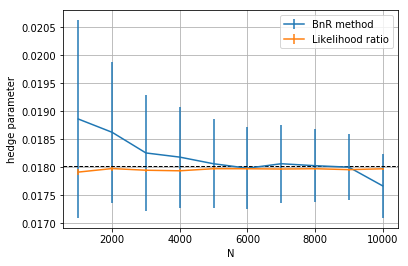

In [18]:
deltas1, deltas2, errors1, errors2 = [], [], [], []

def likelihood(S0, r, sigma, T, K, shift_value, N, digital=False):
        
        data = []
        
        for i in range(1000):
            data2 = [payoff(S0, r, sigma, T, K, shift_value, digital) for i in range(N)]
            data.append(np.mean(
                [np.exp(-r*T)*I*Z/(S0*sigma*np.sqrt(T)) for (I,Z) in data2]))
            
        ci95 = 1.96*np.std(data)/np.sqrt(1000)
        
        return np.mean(data), ci95


with tqdm(len(Ns), disable=False) as pbar:
  
    for N in Ns:

        delta1, error1 = bump_revalue(S0, r, sigma, T, K, shift_value, N, change_seed=False, digital=True)
        deltas1.append(np.absolute(delta1))
        errors1.append(error1)

        delta2, error2 = likelihood(S0, r, sigma, T, K, shift_value, N, digital=True)
        deltas2.append(np.absolute(delta2))
        errors2.append(error2)

        pbar.update()
         
plt.errorbar(Ns, deltas1, yerr=errors1, label="BnR method") 
plt.errorbar(Ns, deltas2, yerr=errors2, label="Likelihood ratio") 

plt.xlabel('N')
plt.ylabel('hedge parameter')
plt.grid()
plt.legend(loc='best')
plt.axhline(0.0180243, ls='--', c='k', lw=1.)
plt.show()

### Estimation of Sensitivities in MC

    1. Derive an analytical expression for the price of an Asian option that is based on geometric averages.

In [19]:
def geometric_mean(iterable):
    a = np.array(iterable)
    
    return np.exp(np.sum(np.log(a))/a.size)

def anal_asian(T, N, S_0, K, r, sigma):
    
    mu = (r - sigma**2/2)*((N+1)/(2*N))
    sigma2 = (N+1)*(2*N+1)*sigma**2/(6*N**2)
    S_0 = S_0*np.exp((mu-r+sigma2/2)*T)
    
    d1 = (np.log(S_0/K) + (r + sigma2/2)*T)/np.sqrt(T*sigma2)
    d2 = d1 - np.sqrt(T*sigma2)
    
    c = S_0*norm.cdf(d1) - np.exp(-r*T)*K*norm.cdf(d2)
    return c

def payoff_asiancall(S0, r, sigma, T, K):
      
    Z = np.random.normal()

    ST = S0
    steps = 365
    S_values = []
    for t in range(steps):
       ST += ST*(r/steps + sigma*np.sqrt(1/steps)*np.random.normal())
       S_values.append(ST)

    A = geometric_mean(S_values)

    payoff = max(A-K,0)

    return payoff, Z
      
def mc_asian(T, N, S_0, K, r, sigma, trials):
            
    data = []

    for i in range(10):
        data.append(np.exp(-r*T)*np.mean([payoff_asiancall(S0, r, sigma, T, K)[0] for i in range(trials)]))

    ci95 = 1.96*np.std(data)/np.sqrt(10)

    return np.mean(data), ci95


0it [00:00, ?it/s]

Analytical value: 6.348905934379616


10it [1:38:35, 877.43s/it]


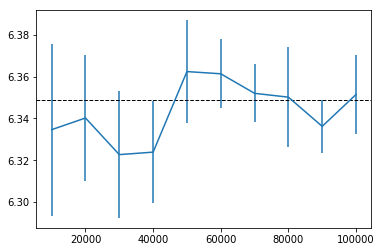

In [21]:
N = 365

print("Analytical value: " + str(anal_asian(T, N, S0, K, r, sigma)))

prices, yerrs = [], []
trials = [10000*i for i in range(1, 11)]



with tqdm(len(Ns), disable=False) as pbar:
  
    for trial in trials: 
        price, error = mc_asian(T, N, S0, K, r, sigma, trial)

        prices.append(price)
        yerrs.append(error)
        pbar.update()
    
plt.errorbar(trials, prices, yerr=yerrs)
plt.axhline(anal_asian(T, N, S0, K, r, sigma), ls='--', c='k', lw=1.)kelihood ratio") 
plt.xlabel('N')
plt.ylabel('estimation')

